<h1 style="text-align: center;">Medical Image Segmentation with Foundation Models – The Case of BiomedParse</h1>

---
Welcome to this hands-on session on the medical image segmentation with foundation models. Medical image segmentation is the process of delineating (1) anatomical structures or (2) pathological regions in medical images—e.g., identifying tumors in MRI scans.

📌 `BiomedParse`(https://microsoft.github.io/BiomedParse/) is an advanced biomedical foundation model that unifies three core tasks in biomedical image analysis—segmentation, detection, and recognition—within a single, integrated framework across nine diverse imaging modalities. 

Inference Process:

Input: Image + natural language prompt.

Output: Segmentation masks + object labels in one pass.

📌 [[`Paper`](https://aka.ms/biomedparse-paper)] : Zhao, T., Gu, Y., Yang, J. et al. A foundation model for joint segmentation, detection and recognition of biomedical objects across nine modalities. Nat Methods 22, 166–176

📌 [[`Model`](https://huggingface.co/microsoft/BiomedParse)]: Combines vision encoder and language-guided segmentation head.

<img src="img/fig2.png" width="800">

📌 [[`Data`](https://huggingface.co/datasets/microsoft/BiomedParseData)]: Over 6 million image–mask–description triples from 45 datasets

<img src="img/fig1.png" width="500">


## 👉 Can we achieve good segmentation results for abdomen CT and chest X-rays (CXR)? 

## Let’s find out!
---

## Download the model from HuggingFace (Optional)

The BiomedParse model checkpoint is hosted on [HuggingFace](https://huggingface.co/microsoft/BiomedParse). 
This step ensures secure and authorized access to the model resources.

In [1]:
# # Authenticate user for HuggingFace if needed. Enter token below if requested.
# from huggingface_hub.utils import HfFolder

# if HfFolder.get_token() is None:
#     from huggingface_hub import notebook_login
#     notebook_login()

# from huggingface_hub import hf_hub_download
# model_file = hf_hub_download(repo_id="microsoft/BiomedParse", filename="biomedparse_v1.pt", local_dir="./pretrained")
# print(f"Downloaded model file to: {model_file}")

## Use your designated GPU

In [2]:
import os

# Specify which GPU to use
GPU = 4  # Change this to your desired GPU device

os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPU}"
print(f"Using GPU device: {GPU}")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"    # Enable synchronous CUDA operations for debugging

os.chdir(os.path.expanduser("~") + '/BiomedParse_demo/BiomedParse')
print(os.getcwd())

Using GPU device: 4
/home/jupyter-po-chih/BiomedParse_demo/BiomedParse


## Load the model weights

In [3]:
from PIL import Image
import torch
import argparse
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed # changed from utils
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image

conf_files = "./configs/biomedparse_inference.yaml"
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

model_file = "./pretrained/biomedparse_v1.pt"

model = BaseModel(opt, build_model(opt)).from_pretrained(model_file).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/mnt/efs/data/envs/biomedparse/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/efs/data/envs/biomedparse/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Deformable Transformer Encoder is not available.


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

def overlay_masks(image, masks, colors):
    overlay = image.copy()
    overlay = np.array(overlay, dtype=np.uint8)
    for mask, color in zip(masks, colors):
        overlay[mask > 0] = (overlay[mask > 0] * 0.4 + np.array(color) * 0.6).astype(np.uint8)
    return Image.fromarray(overlay)

def generate_colors(n):
    cmap = plt.get_cmap('tab10')
    colors = [tuple(int(255 * val) for val in cmap(i)[:3]) for i in range(n)]
    return colors

## 🔥 Part 1: Test on Abdominal CT for Organ Segmentation

Dataset: https://github.com/JunMa11/AbdomenCT-1K

### Step 0. Specify Task

In [5]:
case_id = 'Case_00020'
prompts = ['liver', 'kidney', 'spleen', 'pancreas']
label_dict = {'liver': 50, 'kidney': 100, 'spleen': 150, 'pancreas': 200}
window='Original'

### Step 1. Load Image

In [6]:
base_path='../sample_ct/'
img_path = f'{base_path}{case_id}_{window}.png'
msk_path = f'{base_path}{case_id}_msk.png'
    
# Load and process original image
image = Image.open(img_path, formats=['png'])
image = image.convert('RGB')

# Load and process ground truth masks
gt_masks = []
gt_mask_all = Image.open(msk_path, formats=['png'])

for prompt in label_dict.keys():
    gt_mask = 1 * (np.array(gt_mask_all.convert('RGB'))[:, :, 0] == label_dict[prompt])
    gt_masks.append(gt_mask)

### Step 2. Make Prediction

In [7]:
pred_mask = interactive_infer_image(model, image, prompts)

### Step 3. Evaluate Restuls

The **Dice score** (Dice Similarity Coefficient, DSC) measures the overlap between two sets—commonly used in image segmentation to compare a predicted mask with the ground truth:

$$ \mathrm{Dice}(A,B) = \frac{2|A \cap B|}{|A| + |B|} $$


- $A$: predicted positive pixels  
- $B$: ground-truth positive pixels  
- $|A \cap B|$: true positives


📌 Note that pred_mask contains continuous values between 0 and 1. The classification of a pixel as positive depends on the chosen threshold. What happens if you adjust this threshold?

In [8]:
# Calculate dice scores

threshold=0.5

dice_scores = {}
for i, pred in enumerate(pred_mask):
    if i < len(gt_masks):
        gt = gt_masks[i]
        pred_binary = 1 * (pred > threshold)
        intersection = (pred_binary & gt).sum()
        dice = intersection * 2.0 / (pred_binary.sum() + gt.sum())
        dice_scores[prompts[i]] = dice
        print(f'Dice score for {prompts[i]}: {dice:.4f}')

Dice score for liver: 0.7616
Dice score for kidney: 0.8643
Dice score for spleen: 0.9036
Dice score for pancreas: 0.9116


### Step 4. Visualize Results

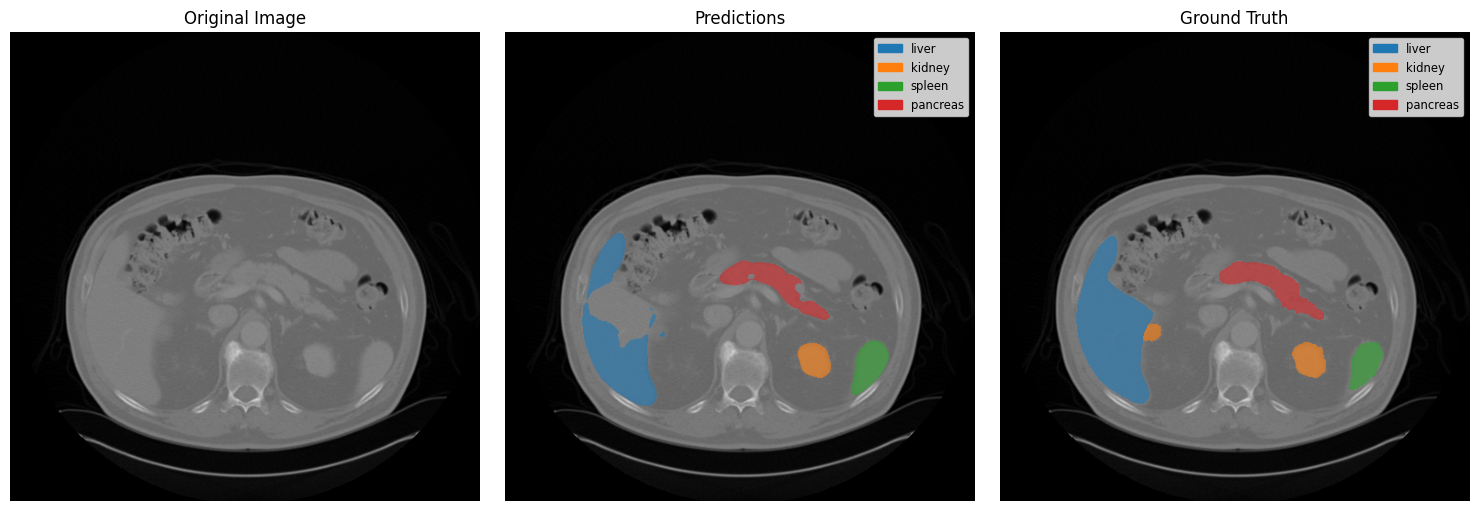

In [9]:
# Generate colors and overlays
colors_pred = generate_colors(len(prompts))
colors_gt = generate_colors(len(gt_masks))

pred_overlay = overlay_masks(image, [1 * (pred_mask[i] > threshold) for i in range(len(prompts))], colors_pred)
gt_overlay = overlay_masks(image, gt_masks, colors_gt)

# Create legend patches
legend_patches_pred = [mpatches.Patch(color=np.array(color_pred) / 255, label=prompt) 
                      for color_pred, prompt in zip(colors_pred, prompts)]
legend_patches_gt = [mpatches.Patch(color=np.array(color_gt) / 255, label=prompt) 
                    for color_gt, prompt in zip(colors_gt, list(label_dict.keys()))]

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(pred_overlay)
axes[1].set_title("Predictions")
axes[1].axis('off')
axes[1].legend(handles=legend_patches_pred, loc='upper right', fontsize='small')

axes[2].imshow(gt_overlay)
axes[2].set_title("Ground Truth")
axes[2].axis('off')
axes[2].legend(handles=legend_patches_gt, loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

### Try different windowing (Re-run Steps 1~4)

Windowing will change the appearance of the picture to **highlight particular structures**. The brightness of the image is adjusted via the window level. The contrast is adjusted via the window width. (https://radiopaedia.org/articles/windowing-ct?lang=us)

**Abdomen** <br>
The values below are written as width and level (W:x L:y) in Hounsfield units (HU). 
- soft tissues W:400 L:50
- liver W:150 L:30

In [10]:
window='SoftTissue'
#window='Liver'

### Try different images and organs (Re-run Steps 1~4)

In [11]:
case_id = 'Case_00631'
prompts = ['liver', 'kidney', 'spleen', 'pancreas', 'aorta']
label_dict = {'liver': 50, 'kidney': 100, 'spleen': 150, 'pancreas': 200, 'aorta': 250}

## 🔥 Part 2: Test on Chest X-ray (CXR) for Pneumothorax Segmentation
Dataset: SIIM-ACR (https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation)

### Step 0. Specify Task

In [12]:
case_id = '1.2.276.0.7230010.3.1.4.8323329.5602.1517875188.985234'
prompts = ['pneumothorax']
label_dict = {'pneumothorax':255}

### Step 1. Load Image

In [13]:
base_path = '../sample_cxr/'
img_path = f'{base_path}{case_id}.png'
msk_path = f'{base_path}{case_id}_msk.png'

image = Image.open(img_path, formats=['png'])
image = image.convert('RGB')

gt_masks = []
gt_mask_all = Image.open(msk_path, formats=['png'])

for prompt in label_dict.keys():
    gt_mask = 1 * (np.array(gt_mask_all.convert('RGB'))[:, :, 0] == label_dict[prompt])
    gt_masks.append(gt_mask)

### Step 2. Make Prediction

In [14]:
pred_mask = interactive_infer_image(model, image, prompts)

### Step 3. Evaluate Restuls


In [15]:
threshold=0.5

dice_scores = {}
for i, pred in enumerate(pred_mask):
    if i < len(gt_masks):
        gt = gt_masks[i]
        pred_binary = 1 * (pred > threshold)
        intersection = (pred_binary & gt).sum()
        dice = intersection * 2.0 / (pred_binary.sum() + gt.sum())
        dice_scores[prompts[i]] = dice
        print(f'Dice score for {prompts[i]}: {dice:.4f}')

Dice score for pneumothorax: 0.1595


### 4. Visualize Results

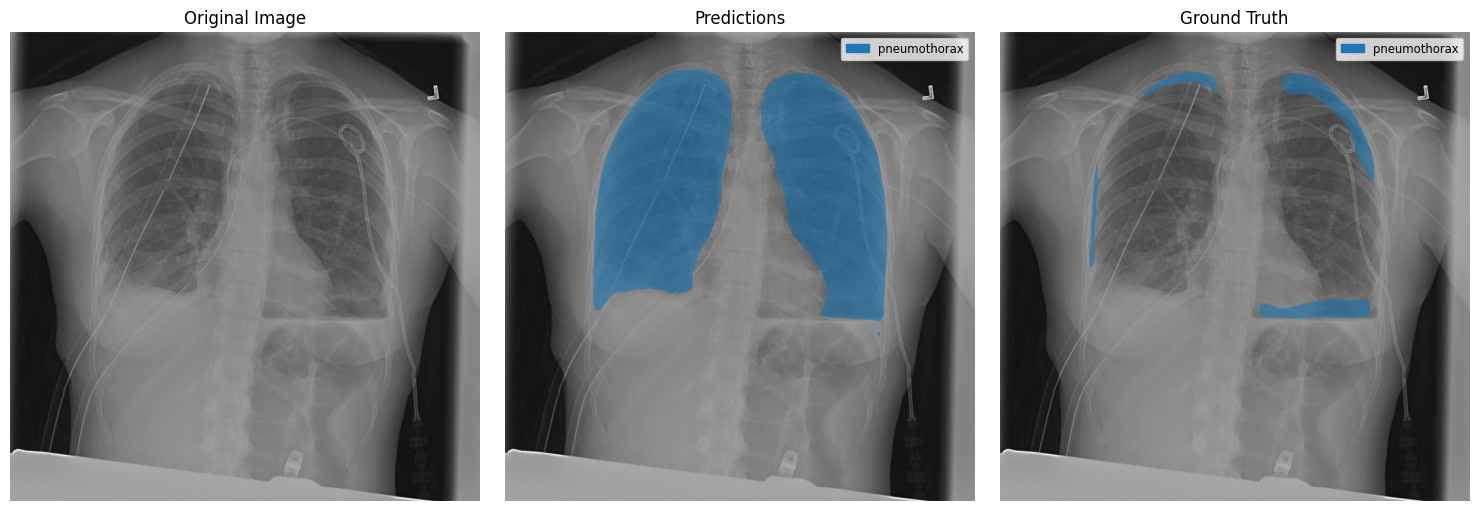

In [16]:
colors_pred = generate_colors(len(prompts))
colors_gt = generate_colors(len(gt_masks))

pred_overlay = overlay_masks(image, [1 * (pred_mask[i] > threshold) for i in range(len(prompts))], colors_pred)
gt_overlay = overlay_masks(image, gt_masks, colors_gt)

legend_patches_pred = [mpatches.Patch(color=np.array(color_pred) / 255, label=prompt) 
                      for color_pred, prompt in zip(colors_pred, prompts)]
legend_patches_gt = [mpatches.Patch(color=np.array(color_gt) / 255, label=prompt) 
                    for color_gt, prompt in zip(colors_gt, list(label_dict.keys()))]

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(pred_overlay)
axes[1].set_title("Predictions")
axes[1].axis('off')
axes[1].legend(handles=legend_patches_pred, loc='upper right', fontsize='small')

axes[2].imshow(gt_overlay)
axes[2].set_title("Ground Truth")
axes[2].axis('off')
axes[2].legend(handles=legend_patches_gt, loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

### 👀 Could it be? This method comes from a Nature Methods paper!

Let’s try the “infection” example (one of the demo prompts) (Re-run Steps 1-4)

Does it work better? 

In [17]:
prompts = ['infection']

### Let's try lung segmentation.

In [18]:
case_id = '1.2.276.0.7230010.3.1.4.8323329.5602.1517875188.985234'
prompts = ['left lung', 'right lung']

In [19]:
pred_mask = interactive_infer_image(model, image, prompts)

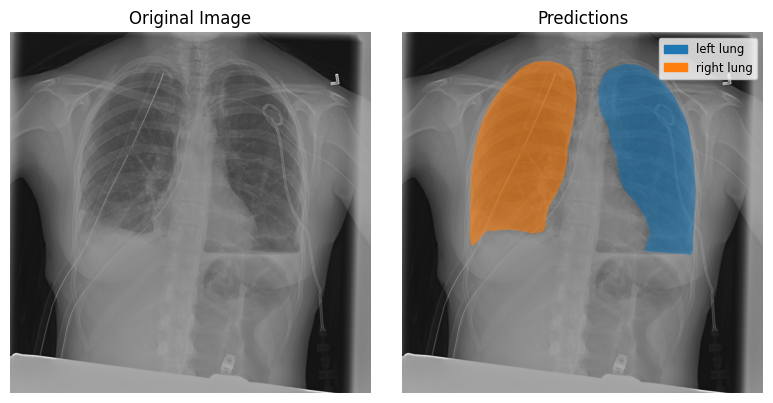

In [20]:
colors_pred = generate_colors(len(prompts))
pred_overlay = overlay_masks(image, [1 * (pred_mask[i] > threshold) for i in range(len(prompts))], colors_pred)
legend_patches_pred = [mpatches.Patch(color=np.array(color_pred) / 255, label=prompt) 
                      for color_pred, prompt in zip(colors_pred, prompts)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(pred_overlay)
axes[1].set_title("Predictions")
axes[1].axis('off')
axes[1].legend(handles=legend_patches_pred, loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

### 🌈 Pretty GOOD! (You may try 'heart')

## Question: Any assumption? Why the fundation model fails to segment pneumothorax?

### Our assumptions:

* The foundation model’s pretraining data lacked sufficient pneumothorax examples.
* Small regions of interest → class imbalance (very few positive pixels compared to background).
    * Organs and lungs are large, well-defined structures with strong contrast against background tissues, making them easier for models to learn.
    * Pneumothorax, however: Appears as a subtle, low-contrast region of air in the pleural space.
    * Dice scores and IoU are less stable when the target region is very small.

* Foundation models are optimized for general object boundaries.
    * Without task-specific fine-tuning, foundation models struggle with pathologies that require disease-aware representations, not just geometry.

# Conclusion

* BiomedParse is capable of performing segmentation tasks across different imaging modalities, although not perfect.
* The performance of foundation models in real-world tasks requires further examination.
* Image pre-processing (windowing) matters.

## Other foundaiton models for segmention.

* MedSAM (https://arxiv.org/abs/2304.12306)
* MONAI (Medical Open Network for AI backed by NVIDIA)